.. index:: Methods; Virtual Finite Elements

The main concepts of our virtual element implementation is provided in
<cite data-cite="VEM"></cite>
where we focus on the fourth order problems but the second order problems
are discussed there as well.

# Elliptic Problems

We first consider an elliptic problem with varying coefficients and Dirichlet boundary conditions
\begin{align*}
-\nabla D(x)\nabla u + \mu(x) u &= f, && \text{in } \Omega, \\
u &= g, && \text{on } \partial\Omega,
\end{align*}
with $\Omega=[-\frac{1}{2},1]^2$ and choosing the forcing and the boundary conditions
so that the exact solution is equal to
\begin{align*}
u(x,y) &= xy\cos(\pi xy)
\end{align*}

First some setup code:

In [1]:
try:
    import dune.vem
except:
    print("This example needs 'dune.vem' - skipping")
    import sys
    sys.exit(0)

from matplotlib import pyplot
import numpy
from dune.grid import cartesianDomain, gridFunction
from dune.fem.plotting import plotPointData as plot
from dune.fem.function import discreteFunction
from dune.fem import integrate
import dune.fem

from ufl import *
import dune.ufl

We use a grid build up of voronoi cells around $50$ random points
in the interval $[-\frac{1}{2},1]\times [-\frac{1}{2},1]$ using 100
iterations of Lloyd's algorithm to improve the quality of the grid.

In [2]:
polyGrid = dune.vem.polyGrid( dune.vem.voronoiCells([[-0.5,-0.5],[1,1]], 50, lloyd=100) )

One can also use a standard simplex or cube grid, e.g.,
polyGrid = dune.vem.polyGrid( cartesianDomain([-0.5,-0.5],[1,1],[10,10]), cubes=False)

In general we can construct a `polygrid` by providing a dictionary with
the `vertices` and the `polygons`. The `voronoiCells` function creates
such a dictionary using random seeds to generate voronoi cells which are
cut off using the provided `cartesianDomain`. The seeds can be
provided as list of points as second argument:
```
voronoiCells(constructor, towers, fileName=None, load=False):
```
If a `fileName` is provided the seeds will be written to disc or if that
file exists they will be loaded from that file if `load=True`,
to make results reproducible.

As an example an output of `voronoiCells(constructor,5)` is
```
{'polygons': [ [4, 5, 2, 3], [ 8, 10,  9,  7], [7, 9, 1, 3, 4],
               [11, 10,  8,  0], [8, 0, 6, 5, 4, 7] ],
 'vertices': [ [ 0.438, 1.  ],    [ 1. , -0.5 ],
               [-0.5, -0.5  ],    [ 0.923, -0.5 ],
               [ 0.248,  0.2214], [-0.5,  0.3027],
               [-0.5,  1. ],      [ 0.407,0.4896],
               [ 0.414,  0.525],  [ 1.,  0.57228],
               [ 1., 0.88293],    [ 1.,  1. ] ] }
```

Let's take a look at the grid with the 50 polygons triangulated

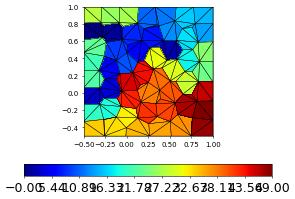

In [3]:
indexSet = polyGrid.indexSet
@gridFunction(polyGrid, name="cells")
def polygons(en,x):
    return polyGrid.hierarchicalGrid.agglomerate(indexSet.index(en))
polygons.plot(colorbar="horizontal")

The vem space is now setup in exactly the same way as usual but the type
of space constructed is defined by the final argument which defines the
moments used on the subentities of a given codimension. So
`testSpaces=[-1,order-1,order-2]` means: use no vertex values (-1),
order-1 moments on the edges and order-2 moments in the inside. So this
gives us a non-conforming space for second order problems - while using
`testSpaces=[0,order-2,order-2]` defines a conforming space.

In [4]:
order = 1
space = dune.vem.vemSpace( polyGrid, order=order, storage="numpy",
                           testSpaces=[-1,order-1,order-2])

Now we define the model starting with the exact solution:

In [5]:
x = SpatialCoordinate(space)
u = TrialFunction(space)
v = TestFunction(space)

exact = x[0]*x[1] * cos(pi*x[0]*x[1])

massCoeff = 1+sin(dot(x,x))       # factor for mass term
diffCoeff = 1-0.9*cos(dot(x,x))   # factor for diffusion term

a = (diffCoeff*inner(grad(u),grad(v)) + massCoeff*dot(u,v) ) * dx

# finally the right hand side and the boundary conditions
b = (-div(diffCoeff*grad(exact)) + massCoeff*exact ) * v * dx
dbc = [dune.ufl.DirichletBC(space, exact, i+1) for i in range(4)]

Finally, we can construct the solver passing in the space the pde
description and arguments for stabilization:

size of space: 151


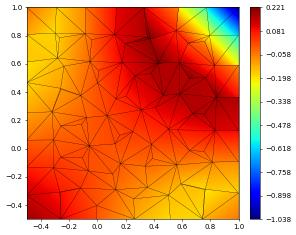

In [6]:
parameters = {"nonlinear.verbose": False,
              "linear.tolerance": 1e-12,
              "linear.preconditioning.method": "jacobi",
              "linear.verbose": False,
              "penalty": 10*order*order,  # for the dg schemes
              }
df = space.function(name="solution")
scheme = dune.vem.vemScheme( [a==b, *dbc], space, solver="cg",
                             gradStabilization=diffCoeff,
                             massStabilization=massCoeff,
                             parameters=parameters )
info = scheme.solve(target=df)
print("size of space:",space.size,flush=True)
df.plot()

Repeating the same test with a H^1-conforming space

size of space: 102


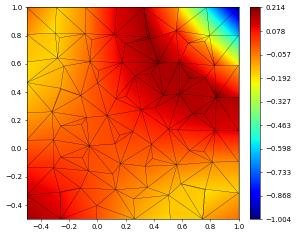

In [7]:
space = dune.vem.vemSpace( polyGrid, order=order, storage="numpy",
                           testSpaces=[0,order-2,order-2])
df = space.function(name="solution")
scheme = dune.vem.vemScheme( [a==b, *dbc], space, solver="cg",
                             gradStabilization=diffCoeff,
                             massStabilization=massCoeff,
                             parameters=parameters )
info = scheme.solve(target=df)
print("size of space:",space.size,flush=True)
df.plot()

The Vem spaces have an additional method :code:diameters which returns
estimation of the polygon sizes. Note that for technical reasons this is at the
time of writing not available on the grid itself.
A estimate of the minimum and the maximum bounding box diameters are
returned. Note that this is just an estimate of the actual polygon
diameters.

In [8]:
print("Polygon diameters:",space.diameters())

Polygon diameters: (0.20861817075454125, 0.27371479557820927)


We can compare different method, e.g., a lagrange/dg scheme (on the the subtriangulation),
a bounding box dg method and conforming/non conforming VEM:

In [9]:
methods = [ ### "[legend,space,scheme,spaceKwargs,schemeKwargs]"
            ["lagrange",
             dune.fem.space.lagrange,dune.fem.scheme.galerkin,{},{}],
            ["dg",
             dune.fem.space.dgonb, dune.fem.scheme.dg,  {}, {"penalty":diffCoeff}],
            ["vem-conforming",
             dune.vem.vemSpace,    dune.vem.vemScheme,
                {"testSpaces":[0,order-2,order-2]},  # conforming vem space
                {"gradStabilization":diffCoeff, "massStabilization":massCoeff}],
            ["vem-nonconforming",
             dune.vem.vemSpace,    dune.vem.vemScheme,
                 {"testSpaces":[-1,order-1,order-2]},  # non-conforming vem space
                 {"gradStabilization":diffCoeff, "massStabilization":massCoeff}],
            ["bb-dg",
             dune.vem.bbdgSpace,   dune.vem.bbdgScheme, {}, {"penalty":diffCoeff}],
   ]

We now define a function to compute the solution and the $L^2,H^1$ error
given a grid and a space

In [10]:
def compute(grid, space,spaceArgs, schemeName,schemeArgs):
    space = space( grid, order=order, **spaceArgs )
    df = space.function(name="solution")
    scheme = schemeName( [a==b, *dbc], space, solver="cg", **schemeArgs,
                         parameters=parameters )
    info = scheme.solve(target=df)

    # compute the error
    edf = exact-df
    err = [inner(edf,edf),
           inner(grad(edf),grad(edf))]
    errors = [ numpy.sqrt(e) for e in integrate(err) ]

    return df, errors, info

Finally we iterate over the requested methods and solve the problems

method ( lagrange ): dofs:  102 L^2:  0.01798548331856821 H^1:  0.36232002685131237 59


method ( dg ): dofs:  522 L^2:  0.012027648394843136 H^1:  0.33537408516742956 670


method ( vem-conforming ): dofs:  102 L^2:  0.021243937449568658 H^1:  0.3371985482158915 30


method ( vem-nonconforming ): dofs:  151 L^2:  0.01941195042665683 H^1:  0.3505101202766278 32


method ( bb-dg ): dofs:  150 L^2:  0.02008319030236639 H^1:  0.3686869537853158 85


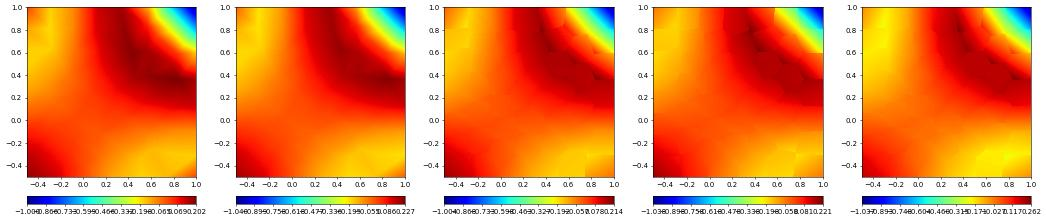

In [11]:
fig = pyplot.figure(figsize=(5*len(methods),10))
figPos = 111+10*len(methods)
for i,m in enumerate(methods):
    dfs,errors,info = compute(polyGrid, m[1],m[3], m[2],m[4])
    print("method (",m[0],"):",
          "dofs: ",dfs.space.size,
          "L^2: ", errors[0], "H^1: ", errors[1],
          info["linear_iterations"], flush=True)
    dfs.plot(figure=(fig,figPos+i), gridLines=None, colorbar="horizontal")

# Nonlinear Elliptic Problem
We can easily set up a non linear problem

non linear problem: [np.float64(0.010347187199960793), np.float64(0.15415768009757938)]


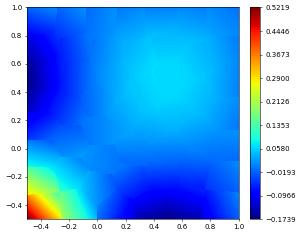

In [12]:
# space = dune.vem.vemSpace( polyGrid, order=1, conforming=True )
space = dune.vem.vemSpace( polyGrid, order=1, testSpaces=[-1,0,-1])
u = TrialFunction(space)
v = TestFunction(space)
x = SpatialCoordinate(space)
exact = (x[0] - x[0]*x[0] ) * (x[1] - x[1]*x[1] )
Dcoeff = lambda u: 1.0 + u**2
a = (Dcoeff(u) * inner(grad(u), grad(v)) ) * dx
b = -div( Dcoeff(exact) * grad(exact) ) * v * dx
dbcs = [dune.ufl.DirichletBC(space, exact, i+1) for i in range(4)]
scheme = dune.vem.vemScheme( [a==b, *dbcs], space, gradStabilization=Dcoeff(u),
                             solver="cg", parameters=parameters)
solution = space.function(name="solution")
info = scheme.solve(target=solution)
edf = exact-solution
errors = [ numpy.sqrt(e) for e in
           integrate([inner(edf,edf),inner(grad(edf),grad(edf))]) ]
print("non linear problem:", errors )
solution.plot(gridLines=None)

# Linear Elasticity
Next we solve a linear elasticity equation using a conforming VEM space:

First we setup the domain

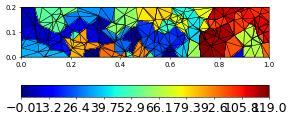

In [13]:
L, W = 1, 0.2

beamGrid = dune.vem.polyGrid( dune.vem.voronoiCells([[0,0],[L,W]], 120) )
indexSet = beamGrid.indexSet
@gridFunction(beamGrid, name="cells")
def polygons(en,x):
    return beamGrid.hierarchicalGrid.agglomerate(indexSet.index(en))
polygons.plot(colorbar="horizontal")

# instead of providing the moments we can simply add a parameter 'conforming' to construct the H^1-conforming space
space = dune.vem.vemSpace( beamGrid, order=2, dimRange=2, conforming=True)

In [14]:
# some model constants
mu = 1
rho = 1
delta = W/L
gamma = 0.4*delta**2
beta = 1.25
lambda_ = beta
g = gamma

# clamped boundary on the left
x = SpatialCoordinate(space)
dbc = dune.ufl.DirichletBC(space, as_vector([0,0]), x[0]<1e-10)

# Define strain and stress
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
def sigma(u):
    return lambda_*nabla_div(u)*Identity(2) + 2*mu*epsilon(u)

# Define the variational problem
u = TrialFunction(space)
v = TestFunction(space)
f = dune.ufl.Constant((0, -rho*g))
a = inner(sigma(u), epsilon(v))*dx
b = dot(as_vector([0,-rho*g]),v)*dx

# Compute solution
displacement = space.function(name="displacement")
scheme = dune.vem.vemScheme( [a==b, dbc], space,
        gradStabilization = as_vector([lambda_+2*mu, lambda_+2*mu]),
        solver="cg", parameters=parameters )
info = scheme.solve(target=displacement)

Show the magnitude of the displacement field, stress and the deformed beam

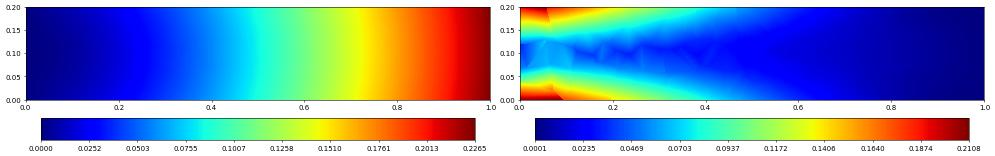

In [15]:
fig = pyplot.figure(figsize=(20,10))
displacement.plot(gridLines=None, figure=(fig, 121), colorbar="horizontal")
s = sigma(displacement) - (1./3)*tr(sigma(displacement))*Identity(2)
von_Mises = sqrt(3./2*inner(s, s))
plot(von_Mises, gridView=beamGrid, gridLines=None, figure=(fig, 122), colorbar="horizontal")

Finally we plot the deformed beam

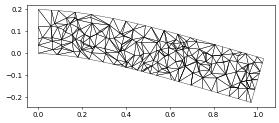

In [16]:
from dune.fem.view import geometryGridView
position = space.interpolate( x+displacement, name="position" )
beam = geometryGridView( position )
beam.plot()

# Fourth order problem
As final example we solve some fourth order PDEs using a non-conforming VEM
space for $H^2$ functions. To construct the space we just need to define
a suitable 'moments' vector to construct a suitable space for $H^2$ problems.

In [17]:
ncC1testSpaces = [ [0], [order-3,order-2], [order-4] ]

We test the method using a biharmonic problem.
\begin{align*}
-\Delta^2 u &= f, && \text{in } \Omega, \\
u &= g, && \text{on } \partial\Omega, \\
\nabla u.n &= 0, && \text{on } \partial\Omega,
\end{align*}

__Note__:
      For function with continuous derivatives we have
      laplace(u)*laplace(v)*dx = inner(u,v)*dx
      as can be seen by using integration by parts on the mixed terms on the right
      and using continuity of u,v.
      For the non-conforming spaces we don't have continuity of the
      derivatives so the equivalence does not hold and one should use the
      right hand side directly to obtain a coercive bilinear form w.r.t.
      the norm on $H^2$ (the left is not a norm in this case).
      For computing the forcing term 'b' both formula are fine since
      'exact' is smooth enough.

bi-laplace errors: [np.float64(27.622895041754244), np.float64(152.10638503664237)]


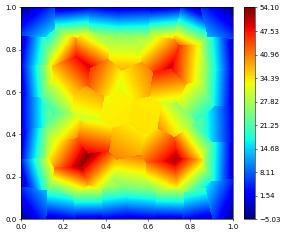

In [18]:
polyGrid = dune.vem.polyGrid( dune.vem.voronoiCells([[0,0],[1,1]], 50, lloyd=100) )
space = dune.vem.vemSpace( polyGrid, order=order, testSpaces=ncC1testSpaces)

x = SpatialCoordinate(space)
exact = sin(2*pi*x[0])**2*sin(2*pi*x[1])**2

laplace = lambda w: div(grad(w))
H = lambda w: grad(grad(w))
u = TrialFunction(space)
v = TestFunction(space)
a = ( inner(H(u),H(v)) ) * dx

# finally the right hand side and the boundary conditions
b = laplace(laplace(exact)) * v * dx
dbcs = [dune.ufl.DirichletBC(space, [0], i+1) for i in range(4)]

scheme = dune.vem.vemScheme( [a==b, *dbcs], space, hessStabilization=1,
                             solver="cg", parameters=parameters )

# solution = space.interpolate(0, name="solution") # issue here for C^1 spaces
solution = discreteFunction(space, name="solution")
info = scheme.solve(target=solution)
edf = exact-solution
errors = [ numpy.sqrt(e) for e in
           integrate([inner(edf,edf),inner(grad(edf),grad(edf))]) ]
print("bi-laplace errors:", errors )
solution.plot(gridLines=None)